# Нейронная на сеть на мобильном устройстве

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_hub as hub

from tqdm import tqdm

print("TensorFlow Version:", tf.__version__)
print("TensorFlow Hub Version: ", hub.__version__)
print('GPU Device Found.' if tf.config.list_physical_devices('GPU') else 'GPU Device Not Found. Running on CPU')

TensorFlow Version: 2.11.0
TensorFlow Hub Version:  0.12.0
GPU Device Not Found. Running on CPU


# Подготовка данных

## Загрузка данных на локальный диск

In [7]:
import urllib.request, urllib.error
import zipfile
import os

# Загрузка архива
url = 'https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip'
fname = 'cats_vs_dogs'
local_zip = urllib.request.urlretrieve(url, fname + '.zip')

Распаковка в текущую директорию. Распакауем все, так как иначе нужная папка (`PetImages`) в данном архиве не обнаруживается.

In [33]:
with zipfile.ZipFile(local_zip, 'r') as zip_ref:
    zip_ref.extractall('./data')

Удалим лишние файлы и переименуем папку с изображениями в удобную для дальнейшего использования - `cats_vs_dogs`.

In [34]:
zip_content = os.listdir('./data')

In [35]:
os.remove('./data/' + zip_content[0])
os.remove('./data/' + zip_content[2])

os.renames('./data/PetImages',
           f'./data/{fname}')

Проверим содержимое папки с изображениями, мы должны увидеть список из папок с названиями классов и количество этих классов. 

In [140]:
# Базовая директория
base_dir = Path('./data/cats_vs_dogs')
# base_dir = '/content/drive/MyDrive/Sber DS/Diploma/data/cats_vs_dogs/'  # for colab
classes = os.listdir(base_dir)

num_classes = len(classes)

# и ее содержимое
print("Содержимое базовой директории:")
print(classes)
print('Количество классов:', num_classes)

Содержимое базовой директории:
['Cat', 'Dog']
Количество классов: 2


Теперь можно удалить загруженный ранее архив.

In [38]:
# deleting the zip file from system
os.remove(fname + '.zip')

## Удалим некорректные файлы

Если в архиве содержатся некорректные ("битые") файлы, то мы получим ошибку на том или ином этапе обучения и подготовки модели к переносу на мобильное устройство. Код ниже позволяет обнаружить и сразу удалить такие файлы при их наличии. Запустим эту функцию для всех папок с классами ([источник кода](https://github.com/tensorflow/datasets/issues/2188)).

In [41]:
from pathlib import Path
from tensorflow.io import read_file
from tensorflow.image import decode_image

def delete_corrupted_files(folder, base_dir):
    for image in sorted((base_dir /f'{folder}').glob('*')):
        try:
            img = read_file(str(image))
            img = decode_image(img)

            if img.ndim != 3:
                print(f"[FILE_CORRUPT] {str(image).split('/')[-1]} DELETED")
                image.unlink()

        except Exception as e:
            print(f"[ERR] {str(image).split('/')[-1]}: {e} DELETED")
            image.unlink()

In [42]:
for folder in classes:
    print(folder)
    delete_corrupted_files(folder, base_dir)

[FILE_CORRUPT] data\cats_vs_dogs\Cat\10125.jpg DELETED
[ERR] data\cats_vs_dogs\Cat\10404.jpg: {{function_node __wrapped__DecodeImage_device_/job:localhost/replica:0/task:0/device:CPU:0}} Unknown image file format. One of JPEG, PNG, GIF, BMP required. [Op:DecodeImage] DELETED
[FILE_CORRUPT] data\cats_vs_dogs\Cat\10501.jpg DELETED
[FILE_CORRUPT] data\cats_vs_dogs\Cat\10820.jpg DELETED
[FILE_CORRUPT] data\cats_vs_dogs\Cat\11210.jpg DELETED
[FILE_CORRUPT] data\cats_vs_dogs\Cat\11565.jpg DELETED
[FILE_CORRUPT] data\cats_vs_dogs\Cat\11874.jpg DELETED
[FILE_CORRUPT] data\cats_vs_dogs\Cat\11935.jpg DELETED
[FILE_CORRUPT] data\cats_vs_dogs\Cat\140.jpg DELETED
[FILE_CORRUPT] data\cats_vs_dogs\Cat\2663.jpg DELETED
[FILE_CORRUPT] data\cats_vs_dogs\Cat\3300.jpg DELETED
[FILE_CORRUPT] data\cats_vs_dogs\Cat\3491.jpg DELETED
[ERR] data\cats_vs_dogs\Cat\4351.jpg: {{function_node __wrapped__DecodeImage_device_/job:localhost/replica:0/task:0/device:CPU:0}} Input size should match (header_size + row_size 

Сохраним пути к субдиректориям с классами в отдельные переменные и посмотрим на конечное количество изображений в каждом классе.

In [145]:
cat_dir = base_dir / classes[0]
dog_dir = base_dir / classes[1]

cat_fnames = os.listdir(cat_dir)
dog_fnames = os.listdir(dog_dir)

print('cat:', len(cat_fnames))
print('dog:', len(dog_fnames))

cat: 12475
dog: 12466


Таким образом, наши классы сбалансированы, в дальнейшем при оценке качества работы модели мы можем использовать метрику `accuracy`, которая показывает число правильно предсказанных объектов. Если же классы были несбалансированы, нам пришлось бы оценивать модель по метрикам `precision` и `recall`, которые позволяют более прицельно оценить качество работы модели (доля правильно предсказанных объектов позитивного класса из всех объектов, помеченных моделью позитивными, и доля правильно предсказанных объектов позитивного класса среди всех истинных позитивных объектов, соответственно).

Посмотрим на названия отдельных файлов в тренировочном наборе фотографий.

In [146]:
print(cat_fnames[90:95])
print(dog_fnames[90:95])

['10078.jpg', '10079.jpg', '1008.jpg', '10080.jpg', '10081.jpg']
['10078.jpg', '10079.jpg', '1008.jpg', '10080.jpg', '10081.jpg']


## Визуализация оригинальных изображений

Посмотрим на восемь фотографий из обеих субдиректорий - 4 фотографии с выжженной территорией и 4 с обычной.

In [62]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

# Parameters for our graph; we'll output images in a 4x4 configuration
nrows = 4
ncols = 4

# Index for iterating over images
pic_index = 0

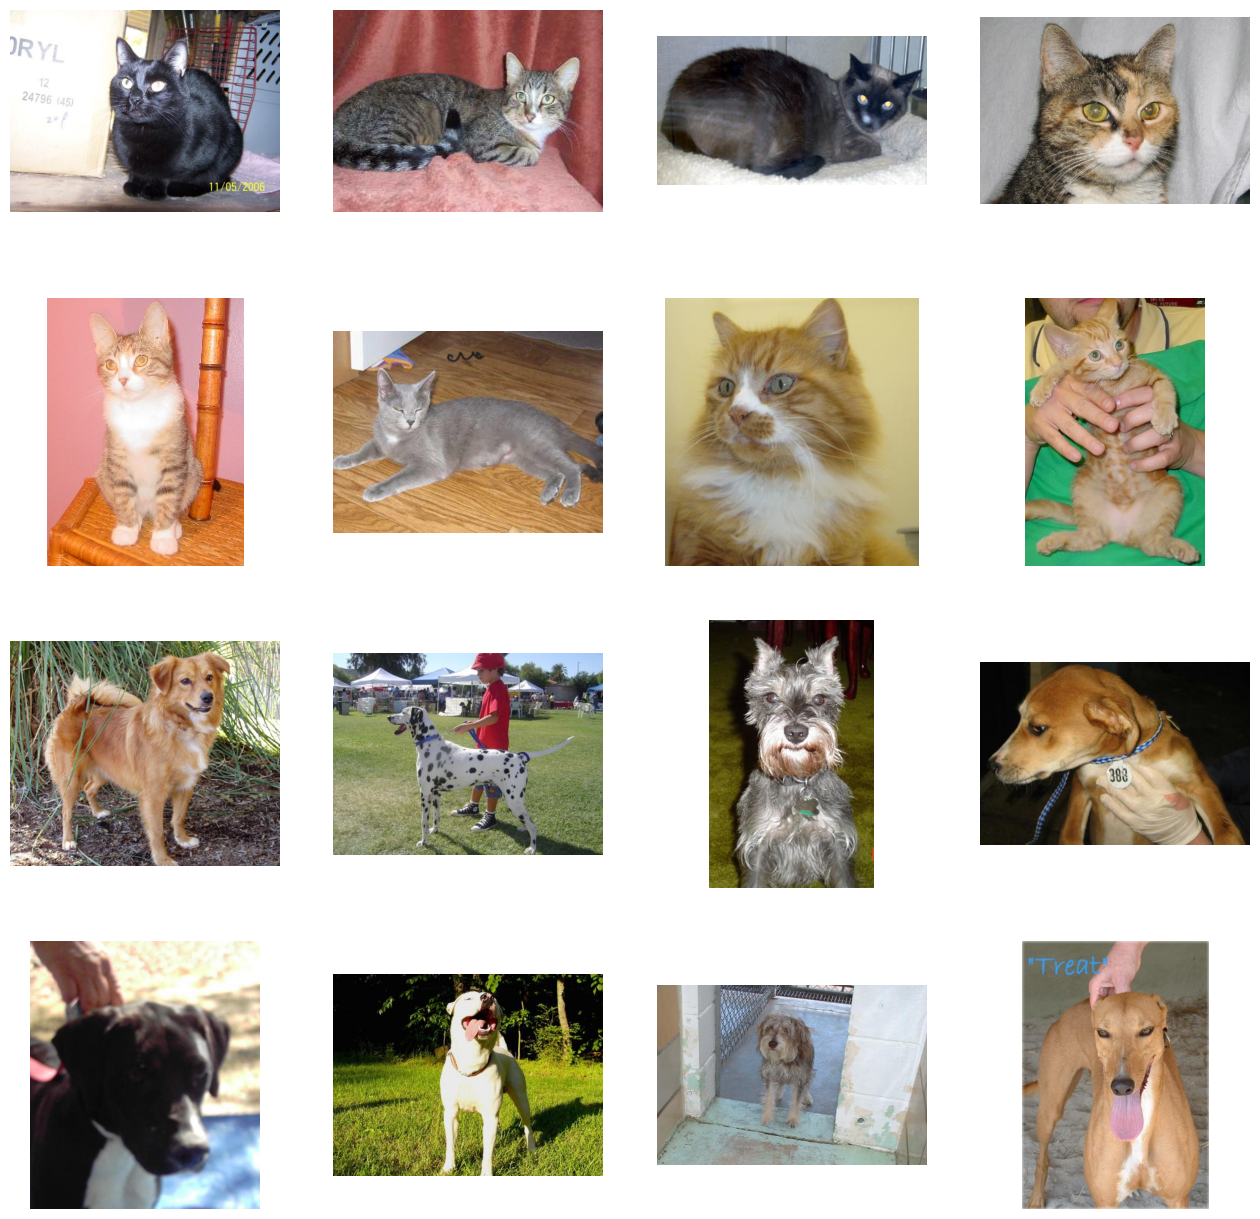

In [64]:
# Запустите эту ячейку несколько раз, чтобы увидеть разные наборы фотографий

fig = plt.gcf()
fig.set_size_inches(ncols*4, nrows*4)

pic_index += 8

next_cat_pic = [os.path.join(cat_dir, fname)
                for fname in cat_fnames[pic_index-8:pic_index]]
next_dog_pic = [os.path.join(dog_dir, fname)
                for fname in dog_fnames[pic_index-8:pic_index]]

for i, img_path in enumerate(next_cat_pic+next_dog_pic):
    # Set up subplot; subplot indices start at 1
    sp = plt.subplot(nrows, ncols, i+1)
    # Отключить оси
    sp.axis(False)
    
    img = mpimg.imread(img_path)
    plt.imshow(img)


Изображения в имеющихся наборах имеют различное разрешение и и соотноешние сторон, поэтому их необходимо привести к единому стандарту на стадии формирования датасетов для нейронной сети. Этим мы сейчас и займемся.

# Гиперпараметры для модели с переносом обучения

В самом начале обозначим гиперпараметры для будущей модели, это позволит нам уже сейчас начать подготавливать необходимые команды с этими данными для дальнейшего использования.

In [86]:
#@param ["(\"mobilenet_v2\", 224, 1280)", "(\"inception_v3\", 299, 2048)"] {type:"raw", allow-input: true}
module_selection = ("mobilenet_v2", 224, 1280) 
handle_base, pixels, FV_SIZE = module_selection
MODULE_HANDLE ="https://tfhub.dev/google/tf2-preview/{}/feature_vector/4".format(handle_base)
IMAGE_SIZE = (pixels, pixels)
BATCH_SIZE = 32
print("Using {} with input size {} and output dimension {}".format(MODULE_HANDLE, IMAGE_SIZE, FV_SIZE))

Using https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4 with input size (224, 224) and output dimension 1280


# Создание датасетов

## Вручную

In [138]:
import shutil
import os
from pathlib import Path

train_dir = Path('./data/train')
validation_dir = Path('./data/validation')
test_dir = Path('./data/test')

cats = 'Cat'
dogs = 'Dog'

# копируем все файлы
# shutil.copytree(src=base_dir, dst='./data_new')

'./data_new'

In [148]:
# Общее количество изображений по классам
cat_imgs_num = len(cat_fnames)
dog_imgs_num = len(dog_fnames)

In [155]:
# Разделим количество изображений на три части
# 8:1:1

cat_train_num, cat_val_num = int(cat_imgs_num/10*8), int(cat_imgs_num/10)
cat_test_num = cat_imgs_num - cat_train_num - cat_val_num

print(cat_train_num, cat_val_num, cat_test_num)

9980 1247 1248


In [156]:
dog_train_num, dog_val_num = int(dog_imgs_num/10*8), int(dog_imgs_num/10)
dog_test_num = dog_imgs_num - dog_train_num - dog_val_num

print(dog_train_num, dog_val_num, dog_test_num)

9972 1246 1248


## Не работает

Для обучения модели и затем конвертации ее в облегченную версию все изображения нам необходимо разделить на три части: тренировочную, валидационную, тестовую. Для выполнения этой задачи будем использовать метод библиотеки `keras` `image_dataset_from_directory`. Так как этот метод позволяет создать только тренировочный и валидационный датасеты, тестовый нам придется создавать вручную, выделяя его из валидационного. Более того, для корректной работы кода, создающего облегченную версию нашей модели, который мы позаимствовали из курса по компьютерному зрению, тренировочный и валидационный датасеты должны иметь достаточно большой батч, тогда как тестовый датасет должен выдавать по одному изображению зараз, то есть батч должен равняться 1. 

Весь необходимый код оформим в функцию, которая и проделает все операции.

In [127]:
def datasets_prep(base_directory=base_dir,
                  seed=123,
                  batch_size=BATCH_SIZE,
                  image_size=IMAGE_SIZE, 
                  label_mode='binary'):
    
    train_ds = tf.keras.utils.image_dataset_from_directory(
                            base_dir,
                            label_mode=label_mode,
                            validation_split=0.2,
                            subset='training',
                            seed=seed,
                            image_size=IMAGE_SIZE,
                            batch_size=batch_size)
    
    val_ds = tf.keras.utils.image_dataset_from_directory(
                            base_dir,
                            label_mode=label_mode,
                            validation_split=0.2,
                            subset='validation',
                            seed=seed,
                            image_size=IMAGE_SIZE,
                            batch_size=batch_size)
    
    test_ds = tf.keras.utils.image_dataset_from_directory(
                            base_dir,
                            label_mode=label_mode,
                            validation_split=0.2,
                            subset='validation',
                            seed=seed,
                            image_size=IMAGE_SIZE,
                            batch_size=32)  # установим батч = 1
    
    # разделяем валидационный тест на две части
#     val_ds_num = len(val_ds)
#     take = int(val_ds_num/2)
#     test_ds = val_ds.take(take)
#     val_ds = val_ds.skip(take)
    
#     test_ds = test_ds.rebatch(1)
#     # print('Files for final validation dataset:', val_ds.cardinality())
#     print('Files for test dataset:', test_ds.cardinality())
    
    return train_ds, val_ds, test_ds

Проверим корректность метода, который мы применили для выделения тестового датасета из валидационного - изображения в обоих датасетах не должны повторяться.

In [112]:
dataset = tf.data.Dataset.range(10)
take = int(len(dataset)/2)
print(take)

test = dataset.take(take)
print('test:', list(test.as_numpy_iterator()))
dataset = dataset.skip(take)
print('valid:', list(dataset.as_numpy_iterator()))

5
test: [0, 1, 2, 3, 4]
valid: [5, 6, 7, 8, 9]


Как видим, при использовании данной последовательности методов `take` и `skip` элементы действительно разделяются без повторов.

## Датасеты

In [128]:
train_batches, validation_batches, test_batches = datasets_prep()

Found 24941 files belonging to 2 classes.
Using 19953 files for training.
Found 24941 files belonging to 2 classes.
Using 2494 files for validation.
Found 24941 files belonging to 2 classes.
Using 2494 files for validation.


Проверим созданные датасеты на соответствие заданным выше параметрам.

In [105]:
for image_batch, label_batch in train_batches.take(1):
    pass

image_batch.shape

TensorShape([32, 224, 224, 3])

In [106]:
for image_batch, label_batch in validation_batches.take(1):
    pass

image_batch.shape

TensorShape([32, 224, 224, 3])

In [107]:
for image_batch, label_batch in test_batches.take(1):
    pass

image_batch.shape

TensorShape([1, 224, 224, 3])

Как и требовалось, тестовый и валидационный датасеты содержат по 32 батча.

Проверим классы, верно ли отработал данный инструмент.

In [108]:
class_names = train_batches.class_names
class_names

['Cat', 'Dog']

In [109]:
class_names = validation_batches.class_names
class_names

['Cat', 'Dog']

In [110]:
class_names = test_batches.class_names
class_names

['Cat', 'Dog']

In [119]:
test_batches.take(1)

<TakeDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1), dtype=tf.float32, name=None))>

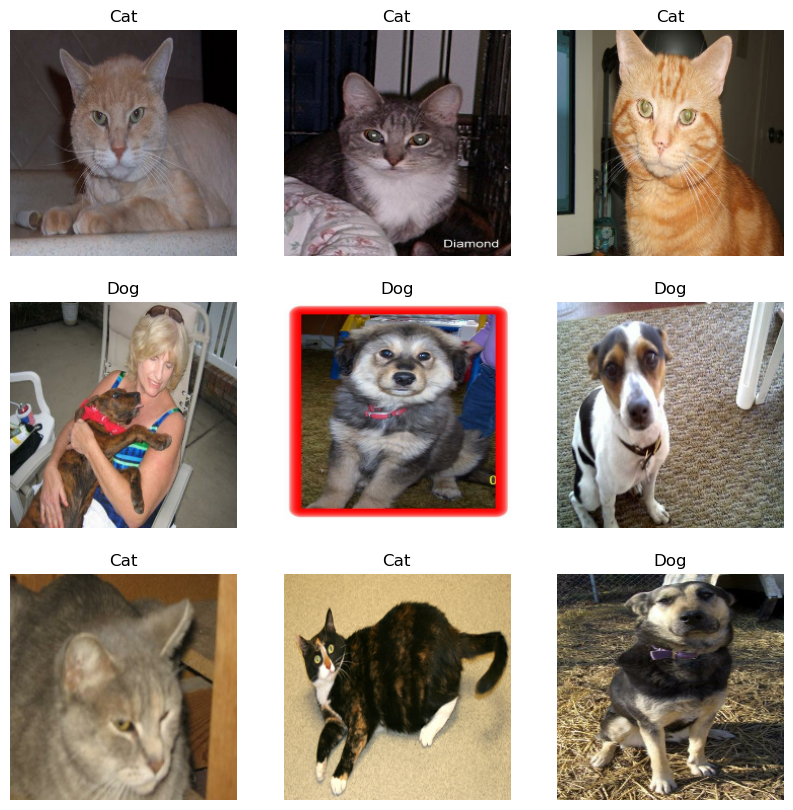

In [129]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in test_batches.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        binary_class = int(labels[i, 0])
        plt.title(class_names[binary_class])
        plt.axis('off')

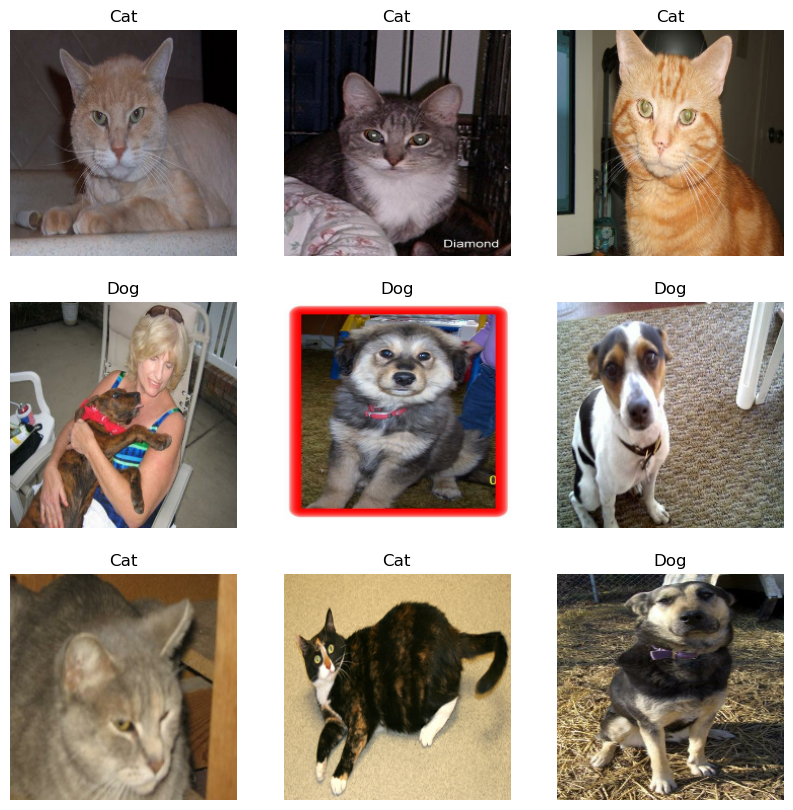

In [121]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in validation_batches.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        binary_class = int(labels[i, 0])
        plt.title(class_names[binary_class])
        plt.axis('off')

Оптимизируем работу кэша следующим кодом:

In [84]:
train_batches = train_batches.cache().prefetch(buffer_size=1)
validation_batches = validation_batches.cache().prefetch(buffer_size=1)

# Подготовка изображений

Создадим слой для будущей модели, который приведет значения изображений к стандартному виду - от `0` до `1`. 